## Remap Series 2: Spray plot and tracking

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing
import mat73

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting as ss
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.helpers import interval_union
from scipy.io import savemat

from spyglass.shijiegu.Analysis_SGU import Footprint,Tracking

In [9]:
pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]  #tetrode channel pairs
color_palet = np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly

In [10]:
def get_footprint(key):
    # for each session and tetrode
    session_key = (QualityMetrics & key).fetch1("KEY")

    '''
    load metric
    '''
    metrics_json_path=(QualityMetrics & session_key).fetch1("quality_metrics_path")
    # Opening JSON file
    with open(metrics_json_path) as json_file:
        metrics_json = json.load(json_file)

    '''
    load extractor and waveform into dict called waves
    '''
    we = Waveforms.load_waveforms(Waveforms,session_key) #extractor

    nwb_units = (CuratedSpikeSorting() & session_key).fetch_nwb()[0]["units"]
    peak_sign = "neg"

    wave=UnitMarks._get_peak_amplitude(
            waveform=we.get_waveforms(1),
            peak_sign="neg",
            estimate_peak_time=True) ## load waveform

    waves={}
    centroids={}
    for unit_id in nwb_units.index:
        wave=UnitMarks._get_peak_amplitude(
            waveform=we.get_waveforms(unit_id),
            peak_sign="neg",
            estimate_peak_time=True)
        timestamps = np.asarray(nwb_units["spike_times"][unit_id])
        sorted_timestamp_ind = np.argsort(timestamps)
        marks = wave[sorted_timestamp_ind]
        timestamps = timestamps[sorted_timestamp_ind]

        waves[unit_id] = -marks
        centroids[unit_id] = np.zeros((1,4))
        for e1 in range(4):
            centroids[unit_id][0,e1] = np.mean(waves[unit_id][:,e1])

    snr = metrics_json['snr']
    accepted_units=[unit_id for unit_id in nwb_units.index if snr[str(unit_id)]>=10]
    print('Accepted units: ', accepted_units)

        
    return accepted_units,waves,centroids

### Specify date, session, and electrode

In [11]:
nwb_copy_file_name = "eliot20221027_.nwb"

### For one session and electrode: 
##### 1) remove noise units
##### 2) find peak amp
##### 3) make spray window

In [14]:
interval_pd=pd.DataFrame((TaskEpoch & {'nwb_file_name':nwb_copy_file_name}).fetch())
session_names=[intvls for intvls in interval_pd.interval_list_name if "Session" in intvls]
print(session_names)
sleep_names=[intvls for intvls in interval_pd.interval_list_name if "Sleep" in intvls]
print(sleep_names)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq1Session4', '10_Seq1Session5', '12_Seq1Session6']
['01_Seq2Sleep1', '03_Seq2Sleep2', '05_Seq2Sleep3', '07_Seq2Sleep4', '09_Seq1Sleep5', '11_Seq2Sleep6', '13_Seq1Sleep7']


In [ ]:
(QualityMetrics & {"nwb_file_name": nwb_copy_file_name,
                                  "sorter":"mountainsort4",
                                  "sort_interval_name":session_names[0]}).fetch("sort_group_id")

array([ 0,  2,  4,  5, 13, 14, 16, 17, 20, 23, 26, 27, 28, 29, 30, 31])

In [11]:
for session in session_names:
    tetrodes = (QualityMetrics & {"nwb_file_name": nwb_copy_file_name,
                                  "sorter":"mountainsort4",
                                  "sort_interval_name":session}).fetch("sort_group_id")
    for tet in tetrodes:
        key = {"nwb_file_name": nwb_copy_file_name,
               "sorter":"mountainsort4",
               "sort_interval_name":session,
               "sort_group_id":tet}
        accepted_units1,waves1,centroids1 = get_footprint(key)
        
        # pool only accepted ones
        centroids1_array=[]
        waves1_array=[]
        waves1_identity=[]
        for u in accepted_units1:
            centroids1_array.append(centroids1[u])
            waves1_array.append(waves1[u])
            waves1_identity.append(np.ones((waves1[u].shape[0],1))*u)
        if len(accepted_units1)>0:
            waves1_array=np.vstack(waves1_array)
            waves1_identity=np.vstack(waves1_identity).ravel().ravel()
            centroids1_array=np.vstack(centroids1_array)
        
            footprint_key = {"A": waves1_array,"ind":waves1_identity,"centroids1":centroids1_array}

            key_waveform = (Waveforms & key).fetch1('KEY')
            #key_waveform["foot_print"] = footprint_key

            outputName = nwb_copy_file_name+'_'+session+'_'+str(tet)+'_SpikeVoltage.mat'
            tracking_path='/cumulus/shijie/recording_pilot/eliot/sorting/'
            output = os.path.join(tracking_path,outputName)
            key_waveform["matfile_path"] = output

            Footprint.insert1(key_waveform,replace=True)
            savemat(output, footprint_key)

[2023-10-08 15:48:55,750][WARNING]: Skipped checksum for file with hash: 5afd96d0-b233-c568-821b-2971b27c70bc, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_GAFKUS0IVO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14]


[2023-10-08 15:48:57,993][WARNING]: Skipped checksum for file with hash: f01c0cbf-1ba0-7a5a-683c-b315ddd5780f, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_GWZL5TB91I.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4]


[2023-10-08 15:48:59,736][WARNING]: Skipped checksum for file with hash: cd0e84f4-bba0-593a-3ef9-ab4eb6cd4963, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_ZGN0UTPKMW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 10, 11, 13, 14, 15, 16, 17, 19]


[2023-10-08 15:49:02,155][WARNING]: Skipped checksum for file with hash: b0b5262f-00fe-05bf-169f-7d184a1c1e9a, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_OBXFGJY5M5.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 6, 9, 10, 12, 13, 14, 18, 19]


[2023-10-08 15:49:04,654][WARNING]: Skipped checksum for file with hash: 0bac0cd8-545f-ddfd-5738-9a94734a5868, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_052TEXVKCW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5, 6, 8, 9, 16, 17, 18, 19, 20, 21, 23]


[2023-10-08 15:49:06,819][WARNING]: Skipped checksum for file with hash: 92341ea9-a97c-8a82-5984-b2bb33f2477b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_2MGEJD4EUD.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 6, 10, 11, 12, 16]


[2023-10-08 15:49:08,893][WARNING]: Skipped checksum for file with hash: 96a37b9c-7b06-a03d-b55c-206311d70259, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AR7Z2ZXYMM.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20]


[2023-10-08 15:49:10,934][WARNING]: Skipped checksum for file with hash: c03959cf-811b-b8bb-2641-4c5a15077829, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_S7EIOK8VYD.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 18, 19]


[2023-10-08 15:49:13,049][WARNING]: Skipped checksum for file with hash: 00914cd6-5574-40d0-e546-f52b1aa4816e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_BC8ZR3KS0A.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 5, 6, 7, 11, 13, 14]


[2023-10-08 15:49:15,333][WARNING]: Skipped checksum for file with hash: 69a2b513-24f9-1eca-90e3-f1bce2f1f425, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_HYMU75RNI2.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [6]


[2023-10-08 15:49:16,765][WARNING]: Skipped checksum for file with hash: 6a0ad374-845c-4fd1-b959-a0f1c81f2e85, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_3HGJQVL5QH.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [6]


[2023-10-08 15:49:18,392][WARNING]: Skipped checksum for file with hash: 2aeca9e1-e1b9-850d-1d2c-9d8ab9179206, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_CSIPLG1VWW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 6, 9, 10, 12, 14, 16, 18, 19]


[2023-10-08 15:49:20,227][WARNING]: Skipped checksum for file with hash: f76b3a99-1b28-59bc-e00a-1efc55bca562, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_H54UAOA8XX.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 5, 11, 12, 14]


[2023-10-08 15:49:22,007][WARNING]: Skipped checksum for file with hash: 321d9fcb-aab5-2dc6-0ae7-77e3e6f5ac39, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_FTUT5X9LSQ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 6, 7, 8, 9, 10, 12]


[2023-10-08 15:49:23,766][WARNING]: Skipped checksum for file with hash: ef7a44c0-f4c9-6078-4599-14d0f1251891, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_W3UO0FSQHE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4]


[2023-10-08 15:49:25,645][WARNING]: Skipped checksum for file with hash: c3094d02-710a-7bf4-70c3-0cfd8ab48356, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_WXCNMBTQAJ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [1, 3, 4, 8, 9, 10, 11, 13, 14]


[2023-10-08 15:49:27,845][WARNING]: Skipped checksum for file with hash: a08e38a7-d3bf-1fae-7529-a512e3ea0210, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_PH7I3D31HW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 5, 6, 9, 10, 11, 17, 18, 19, 20, 21, 22]


[2023-10-08 15:49:32,022][WARNING]: Skipped checksum for file with hash: f79aea0d-47fa-874e-f048-9210ecf83fde, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9ZJ6HO3CYO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 5, 9, 11, 12]


[2023-10-08 15:49:34,180][WARNING]: Skipped checksum for file with hash: 1fdb97c7-8b84-4d00-1dd3-794fd3c088af, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_35CH9ALKH8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21]


[2023-10-08 15:49:36,094][WARNING]: Skipped checksum for file with hash: 2f891401-c8c3-ccdc-3833-13f4d8cad907, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_FP05PWDYVD.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [1, 3, 4, 9, 11, 14, 15, 16, 17]


[2023-10-08 15:49:38,664][WARNING]: Skipped checksum for file with hash: 0c63da15-e0dd-9cfd-6cf6-69ab36efce8d, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1HN6CO7VTG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16]


[2023-10-08 15:49:41,407][WARNING]: Skipped checksum for file with hash: 78ac7dbf-fefe-7df2-04bd-8191ca700d7c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_D93ZQS00P1.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5]


[2023-10-08 15:49:42,961][WARNING]: Skipped checksum for file with hash: 0a3ce4d7-c62a-dac2-b25c-1d8bf4c5f67f, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_WVBYNF9RMP.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  []


[2023-10-08 15:49:44,475][WARNING]: Skipped checksum for file with hash: 36007329-54fb-1126-f9e0-da7426335366, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_HI7HVWFAOE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 6, 7, 9, 11, 13, 14, 16, 17, 18]


[2023-10-08 15:49:46,259][WARNING]: Skipped checksum for file with hash: 981c5ad2-316d-7c34-7239-0ba253369e5b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9JBWZSK24H.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 5, 6, 9]


[2023-10-08 15:49:48,190][WARNING]: Skipped checksum for file with hash: 30b24308-c33f-ed20-2822-6fd8000628bc, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_8P6MH6LXN6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 6, 7, 8, 9, 11, 13, 14]


[2023-10-08 15:49:50,292][WARNING]: Skipped checksum for file with hash: 4f48060c-e02e-6361-000f-fcecbb0443af, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_L8S9HE8H9T.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4]


[2023-10-08 15:49:52,480][WARNING]: Skipped checksum for file with hash: 0a1e82c1-94a6-ae1b-0328-fedd91b55994, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_CO1S1YZP2Z.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16]


[2023-10-08 15:49:54,164][WARNING]: Skipped checksum for file with hash: 8232b6d2-067d-b301-96a5-0bab82aee8bd, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1EFXL33OJT.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 7, 9, 10, 11, 12]


[2023-10-08 15:49:56,448][WARNING]: Skipped checksum for file with hash: 6ab41926-7146-6de4-e079-3ee29d9a4b9c, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MB4USHVD96.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 6, 7, 8, 9, 10, 18, 19, 20, 21]


[2023-10-08 15:50:00,287][WARNING]: Skipped checksum for file with hash: 72319583-d21b-3a2e-dba0-11aca398adfe, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_7S87CPWUI6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 4, 5, 10, 11, 12, 13]


[2023-10-08 15:50:02,078][WARNING]: Skipped checksum for file with hash: eb7fa895-7354-4e33-29ff-eb5e010a0155, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SYB3URNDNI.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5, 6, 7, 8, 11, 12, 13, 14, 16]


[2023-10-08 15:50:04,369][WARNING]: Skipped checksum for file with hash: 49614108-c2b2-3717-5226-99e25a07aa52, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_0AAN6FFYRG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [1, 2, 7, 11, 13, 15, 16, 18, 19, 20]


[2023-10-08 15:50:06,839][WARNING]: Skipped checksum for file with hash: 80d1659d-d5c3-b313-c963-76a3b47444cf, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AW45LYZV0E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 5, 6, 8, 9, 11, 12, 13]


[2023-10-08 15:50:09,164][WARNING]: Skipped checksum for file with hash: d1f5eb50-de8c-eb34-6a5e-efccf46cd0f0, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1VYKELVLIS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 5]


[2023-10-08 15:50:11,089][WARNING]: Skipped checksum for file with hash: 0c9eae9d-0b06-5af4-e805-a9dec9d56d6e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_RJ87G1LQN8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5, 7]


[2023-10-08 15:50:13,191][WARNING]: Skipped checksum for file with hash: bab52bfc-9942-d71f-f10c-a30bfcbcecfa, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_VK5QG7BQ1D.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [6, 7, 8, 11, 12, 13, 14, 15, 17, 19]


[2023-10-08 15:50:15,368][WARNING]: Skipped checksum for file with hash: 1793d5d1-37ca-2977-03a6-77d0201f861e, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9TX1AXEHXP.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 5, 6, 9]


[2023-10-08 15:50:17,501][WARNING]: Skipped checksum for file with hash: 284583e5-81a2-6cab-c8be-a5f6855d4cce, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_FEBV9FYXED.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 7, 8, 11, 12, 13, 14, 15, 16, 17]


[2023-10-08 15:50:19,457][WARNING]: Skipped checksum for file with hash: 4e8660a5-2204-31c9-07f6-0db46a883e53, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_BFA7WWFCQK.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5]


[2023-10-08 15:50:21,263][WARNING]: Skipped checksum for file with hash: 9818866b-92fb-a906-6f3c-14d150500a4b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_5K6F1PH2TD.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21]


[2023-10-08 15:50:23,413][WARNING]: Skipped checksum for file with hash: b20cd5e2-8a65-cb04-b1ff-b60248c0e312, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_A9ZFKC4G4S.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 8, 9, 10, 11, 12, 13, 14]


[2023-10-08 15:50:25,985][WARNING]: Skipped checksum for file with hash: cd72e26b-110e-1a09-e8e2-49d39506fe12, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_6EZ44OC5CP.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 5, 6, 7, 8, 11, 13, 15, 16, 17]


[2023-10-08 15:50:28,118][WARNING]: Skipped checksum for file with hash: 5f44317c-4c72-23e4-b73d-f1b1d09ab508, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_SHIULX3CHD.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 4, 7, 8, 9, 10]


[2023-10-08 15:50:30,565][WARNING]: Skipped checksum for file with hash: 540bd10c-d73b-0206-5c0c-db7538f7d574, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_H1YOHGJVZT.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 5, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22]


[2023-10-08 15:50:33,142][WARNING]: Skipped checksum for file with hash: a13238ab-dd29-c1d6-406f-93db8b413784, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_U6I8TNXJI9.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 7, 9, 12, 14, 16, 18]


[2023-10-08 15:50:35,499][WARNING]: Skipped checksum for file with hash: ab6af69d-9577-72ad-8ea5-b50c896777e4, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_W2Q9LSHB2O.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [5, 6, 7, 8, 9, 10, 13]


[2023-10-08 15:50:37,580][WARNING]: Skipped checksum for file with hash: 6f87bc74-bb51-22c1-d513-79a7f7455edd, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_GDQRCV0XQ5.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 8]


[2023-10-08 15:50:39,603][WARNING]: Skipped checksum for file with hash: 42360a69-a35c-4f08-d973-a586c2f53fe9, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_3X0NKSZ1CG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 8]


[2023-10-08 15:50:41,334][WARNING]: Skipped checksum for file with hash: 4bcd5070-d936-c362-5f6f-083f2b52003b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_OV96TNCND4.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 5, 7, 8, 11, 13, 14, 16, 18]


[2023-10-08 15:50:42,761][WARNING]: Skipped checksum for file with hash: 8c4b30eb-914c-bfbb-337a-d6b5ab7dd5ec, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_AR44OLVU5L.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2]


[2023-10-08 15:50:44,349][WARNING]: Skipped checksum for file with hash: 00a12204-cb90-3488-68f2-95ead69eae9b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_59HBB1J7HK.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 8, 9, 11, 12, 13, 14, 15]


[2023-10-08 15:50:45,887][WARNING]: Skipped checksum for file with hash: e08a07be-d2bd-9c5f-1b22-57cf8ca4d0c6, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_GRBTQNYDV9.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4]


[2023-10-08 15:50:47,365][WARNING]: Skipped checksum for file with hash: 603167c5-c41d-ade0-5750-3bf64359ebff, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_ZGPARGZKSQ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18]


[2023-10-08 15:50:50,798][WARNING]: Skipped checksum for file with hash: 2cb5fa41-13e0-48df-460f-027019065134, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_1ADCZ9OPW8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 8, 9, 12, 13, 14, 15, 16, 19]


[2023-10-08 15:50:54,012][WARNING]: Skipped checksum for file with hash: 9bbdd1c5-5286-b69e-602a-04e8ce3f11df, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_W5X0TCCBSN.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 4, 9, 10, 13, 20, 21, 22, 23]


[2023-10-08 15:50:56,344][WARNING]: Skipped checksum for file with hash: 9c963748-3196-3984-e974-e34f84d12006, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_TKZ1B9M079.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 5, 10, 11]


[2023-10-08 15:50:58,218][WARNING]: Skipped checksum for file with hash: 881987ad-6805-9b03-9956-7c8cce7e18d3, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_NB5QJUS3ZO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [1, 2, 3, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 23, 25, 26, 27, 28]


[2023-10-08 15:51:00,397][WARNING]: Skipped checksum for file with hash: 971301b1-bf7e-f887-f511-e352f542708f, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_LHNP3ESGLL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [6, 7, 8, 9, 10, 14, 17]


[2023-10-08 15:51:02,861][WARNING]: Skipped checksum for file with hash: d73bd682-47f9-e65b-6dc5-b45e59a6cb9b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_QNHFJA9VH7.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 5, 10, 11, 12, 16]


[2023-10-08 15:51:05,754][WARNING]: Skipped checksum for file with hash: 74027228-c89a-d2ce-d3ce-bfa588e26c47, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_4ZO5RCPC9H.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 9]


[2023-10-08 15:51:07,371][WARNING]: Skipped checksum for file with hash: d331a9ac-4554-2db2-a7f8-4a6cfd2551fe, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_RHMGBN22WG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  []


[2023-10-08 15:51:08,748][WARNING]: Skipped checksum for file with hash: 58a80104-420c-f588-6f61-15fa937f7221, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_OL6J1G1IOE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 8, 9, 12, 13, 14, 17, 18]


[2023-10-08 15:51:10,521][WARNING]: Skipped checksum for file with hash: 8ac26d18-ff0d-0a0c-2d4c-cfcdc002fe5b, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_58L12BO9TN.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2]


[2023-10-08 15:51:12,190][WARNING]: Skipped checksum for file with hash: 5be91340-ee2c-b36d-aced-bf32a01b4841, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_9VCLX2JJI7.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4]


[2023-10-08 15:51:14,862][WARNING]: Skipped checksum for file with hash: e1e8dac7-2b36-4737-2d66-df4b2059a7ec, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_6J233UTENQ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 20, 21]


[2023-10-08 15:51:17,453][WARNING]: Skipped checksum for file with hash: d1f6df53-2e53-6aac-0e85-0cf2aa9bcb30, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_QDF0HD14F2.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 5, 6, 9, 11, 12, 13, 14, 16]


[2023-10-08 15:51:19,668][WARNING]: Skipped checksum for file with hash: 1646bfa0-b6d1-5688-78b1-1faa8c6a34d2, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_02WK6C2QRV.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 6, 7, 14, 15, 16]


[2023-10-08 15:51:21,210][WARNING]: Skipped checksum for file with hash: 4e740196-8ffe-9fa4-2aa8-e3bd46e202e1, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_FKWTVGQCCG.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 9, 10, 11, 12, 13, 14, 15]


[2023-10-08 15:51:23,112][WARNING]: Skipped checksum for file with hash: 9291db04-aa4d-6a70-20c3-8efc3ad4a01f, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_KW3PAFRBTH.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 6, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21]


[2023-10-08 15:51:25,937][WARNING]: Skipped checksum for file with hash: b29cdca1-f8b3-fc22-44fa-d881392d7c1f, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_LLMI569KBE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [4, 5, 6, 7, 8, 10, 16, 17]


[2023-10-08 15:51:28,276][WARNING]: Skipped checksum for file with hash: c28ff9cf-9c8e-47a9-33d4-84b0fafe2a78, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_07GW4VX3WX.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 4, 6, 7, 8, 10]


[2023-10-08 15:51:30,109][WARNING]: Skipped checksum for file with hash: 1c356d76-3372-d7e4-7eb5-a9e325c0bf30, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MHUG162PKQ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  []


[2023-10-08 15:51:31,714][WARNING]: Skipped checksum for file with hash: 20eaafc2-fb2c-de59-8138-4b92d0dd18b8, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_E3UBV0COJ0.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [3, 6]


[2023-10-08 15:51:33,515][WARNING]: Skipped checksum for file with hash: 8d630cb9-c4be-108c-616b-4b19ad3125fb, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_86OMEBOD5V.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 4, 6, 8]


[2023-10-08 15:51:35,096][WARNING]: Skipped checksum for file with hash: 0af95c15-23bb-1fb0-23f6-c2e9515ed31d, and path: /stelmo/nwb/analysis/eliot20221027/eliot20221027_MTHD29CEIB.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationW

Accepted units:  [2, 3, 9]


In [56]:
import scipy
'''example how to load mat file back here'''

matfile_path = (Footprint() & {"nwb_file_name":nwb_copy_file_name,
               "sort_group_id":0,
               "sort_interval_name":"06_Seq2Session3"}).fetch1('matfile_path')

Amat=scipy.io.loadmat(matfile_path)
A = Amat['A']
ind = Amat['ind'].ravel()
centroid = Amat['centroids1']

In [218]:
def plot_tetrode(spatial_footprint,ind,centroids,colorvector=[],voltageMax=0):
    '''
    spatial_footprint: (number of spikes x 4 channels of tetrode) negative voltage mV
    ind: (number of spikes) unit id for each spike
    centroids: (2 x 6 x number of units) 6 is 6 pairs of
    colorvector: optional for plotting each spike in different colors
    '''
    color_palet = np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
    color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly
    
    accepted_units = np.unique(ind)

    if len(colorvector)==0:
        colorvector=[]
        color_ind=0
        for u in accepted_units:
            colorvector.append(color_palet[color_ind % color_palet.shape[0]])
            color_ind = color_ind+1
        
    fig,axes=plt.subplots(1,6,figsize=(24,4),sharex=True,sharey=True)

    ## get amplitude and get centroids
    color_ind=0
    for u in accepted_units:
        for p in range(6):
            e1,e2=pair[p]
            x = spatial_footprint[ind==u,e1]
            y = spatial_footprint[ind==u,e2]
            axes[p].scatter(x,y, color=colorvector[color_ind], s=4,alpha = 0.4)
        color_ind = color_ind+1
        

    ## plot centroids
    color_ind=0
    for u in accepted_units:
        for p in range(6):
            e1,e2=pair[p]
            axes[p].scatter(centroids[color_ind,e1],centroids[color_ind,e2],c='k', marker='+',s=12)
        color_ind = color_ind+1
    
    if voltageMax > 0:
        axes[p].set_xlim([-100, voltageMax])
        axes[p].set_ylim([-100, voltageMax])
    return fig,axes

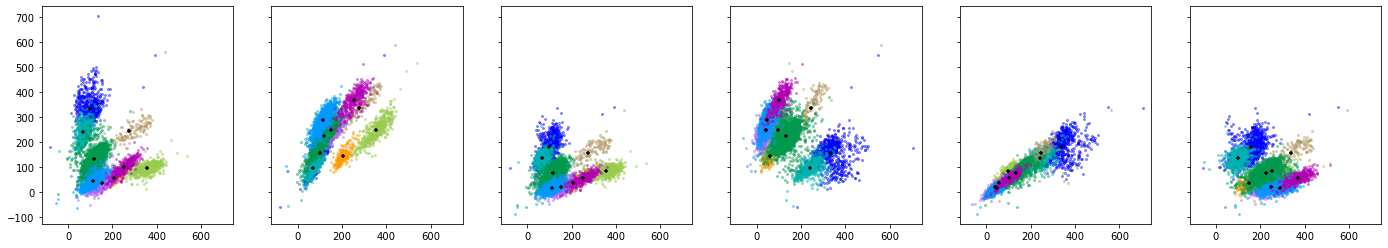

In [62]:
plot_tetrode(A,ind,centroid)

### Set result path before running tracking in MATLAB.

In [13]:
from spyglass.shijiegu.Analysis_SGU import Tracking

In [15]:
# Sleep and Session
sleep_maze_pairs = []
for i in range(len(sleep_names)-1):
    sessionA = sleep_names[i]
    sessionB = session_names[i]
    sleep_maze_pairs.append([sessionA,sessionB])

maze_sleep_pairs=[]
for i in range(len(session_names)):
    sessionA = session_names[i]
    sessionB = sleep_names[i+1]
    maze_sleep_pairs.append([sessionA,sessionB])
    
maze_pairs = []
for i in range(len(session_names)-1):
    sessionA = session_names[i]
    sessionB = session_names[i+1]
    maze_pairs.append([sessionA,sessionB])

In [16]:
maze_pairs

[['02_Seq2Session1', '04_Seq2Session2'],
 ['04_Seq2Session2', '06_Seq2Session3'],
 ['06_Seq2Session3', '08_Seq1Session4'],
 ['08_Seq1Session4', '10_Seq1Session5'],
 ['10_Seq1Session5', '12_Seq1Session6']]

In [27]:
for session_pair in maze_pairs:
    sort_interval_name1,sort_interval_name2 = session_pair
    tetrodes1 = (QualityMetrics & {"nwb_file_name": nwb_copy_file_name,
                                   "sorter":"mountainsort4",
                                   "sort_interval_name":sort_interval_name1}).fetch("sort_group_id")
    tetrodes2 = (QualityMetrics & {"nwb_file_name": nwb_copy_file_name,
                                   "sorter":"mountainsort4",
                                   "sort_interval_name":sort_interval_name2}).fetch("sort_group_id")
    tetrodes = np.intersect1d(tetrodes1,tetrodes2)
    for tet in tetrodes:
        outputName = nwb_copy_file_name+'_'+str(tet)+'_'+sort_interval_name1+'_'+sort_interval_name2+'_tracking.mat'
        tracking_path='/cumulus/shijie/recording_pilot/eliot/tracking/'
        output = os.path.join(tracking_path,outputName)
        key = {"nwb_file_name": nwb_copy_file_name,
               "sort_group_id":tet,"sort_interval_name1":sort_interval_name1,"sort_interval_name2":sort_interval_name2,
               "matfile_path":output}
        Tracking.insert1(key,replace=True)

In [12]:
Tracking() & {"sort_interval_name2":"12_Seq1Session6"}

nwb_file_name,sort_group_id,sort_interval_name1,sort_interval_name2,matfile_path tracking result from MATLAB
eliot20221027_.nwb,2,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_2_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,5,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_5_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,13,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_13_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,14,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_14_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,16,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_16_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,17,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_17_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,20,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_20_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,26,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_26_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,27,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_27_10_Seq1Session5_12_Seq1Session6_tracking.mat
eliot20221027_.nwb,29,10_Seq1Session5,12_Seq1Session6,/cumulus/shijie/recording_pilot/eliot/tracking/eliot20221027_.nwb_29_10_Seq1Session5_12_Seq1Session6_tracking.mat


In [30]:
pd.DataFrame(Tracking()).to_csv(tracking_path+'TrackingRecord.csv',index=True)

In [ ]:
'''
nwb_file_name: varchar(1000)
    sort_group_id: varchar(100)
    sort_interval_name1: varchar(100)
    sort_interval_name2: varchar(100)
    ---
    matfile_path: varchar(1000) #tracking result from MATLAB
'''

### Load result back from MATLAB

In [48]:
import mat73
import scipy

In [63]:
def load_footprint(nwb_copy_file_name,tet,session1):
    matfile_path1 = (Footprint() & {"nwb_file_name":nwb_copy_file_name,
                   "sort_group_id":tet,
                   "sort_interval_name":session1}).fetch1('matfile_path')

    Amat=scipy.io.loadmat(matfile_path1)
    A1 = Amat['A']
    ind1 = Amat['ind'].ravel()
    centroid1 = Amat['centroids1']
    return A1,ind1,centroid1

In [18]:
maze_pairs

[['02_Seq2Session1', '04_Seq2Session2'],
 ['04_Seq2Session2', '06_Seq2Session3'],
 ['06_Seq2Session3', '08_Seq1Session4'],
 ['08_Seq1Session4', '10_Seq1Session5'],
 ['10_Seq1Session5', '12_Seq1Session6']]

In [19]:
tetrodes=np.unique((Tracking() & {'nwb_file_name':nwb_copy_file_name}).fetch('sort_group_id'))
tracked_neurons={}
for tet in tetrodes:
    set1 = []
    for maze_pair in maze_pairs:
        session1,session2=maze_pair
        key = {'nwb_file_name':nwb_copy_file_name,
               "sort_interval_name1":session1,"sort_interval_name2":session2}
        key['sort_group_id']=tet
        try:
            matfile_path = (Tracking() & key).fetch1('matfile_path')
            mat_result=mat73.loadmat(matfile_path)
            tracking=mat_result['pairs'].reshape((-1,2))
            set2=[]
            for t_ind in range(tracking.shape[0]):
                t=tracking[t_ind]
                neuron1=(int(session1[:2]),t[0])
                neuron2=(int(session2[:2]),t[1])
                set2.append({neuron1,neuron2})

            if len(set1)==0:
                set1=set2.copy()
            else:
                for s2 in set2:
                    isdisjoint = np.array([s1.isdisjoint(s2) for s1 in set1])
                    if np.sum(isdisjoint)==len(set1):
                        set1.append(s2)
                    else:
                        set1.append(set1[np.argwhere(~isdisjoint).ravel()[0]].union(s2))
                        set1.remove(set1[np.argwhere(~isdisjoint).ravel()[0]])
            
        
        except:
            continue
        tracked_neurons[tet]=set1
        # if do plotting:
        '''
        A1,ID1,centroid1 = load_footprint(nwb_copy_file_name,tet,session1)
        A2,ID2,centroid2 = load_footprint(nwb_copy_file_name,tet,session2)
        accepted_units1 = np.unique(ID1)
        accepted_units2 = np.unique(ID2)
        colorvector1=np.zeros((len(accepted_units1),3))+0.2
        colorvector2=np.zeros((len(accepted_units2),3))+0.2
        for r_ind in range(tracking.shape[0]):
            u1,u2=tracking[r_ind]
            ind1=np.argwhere(accepted_units1==u1).ravel()
            ind2=np.argwhere(accepted_units2==u2).ravel()
            c = color_palet[r_ind % color_palet.shape[0]]
            colorvector1[ind1,:]=c
            colorvector2[ind2,:]=c
        plot_tetrode(A1,ID1,centroid1,colorvector1)
        plot_tetrode(A2,ID2,centroid2,colorvector2)
        '''


In [21]:
#tracked_neurons

In [22]:
## contain session 
target_sessions= [6,8,10]
neuron_chain = {}
for tet in tracked_neurons.keys():
    neuron_chain_tet=[]
    neurons_tet = tracked_neurons[tet]
    for n in neurons_tet:
        n_session=[n_sub[0] for n_sub in n]
        if np.sum(np.isin(target_sessions,n_session))==len(target_sessions):
            neuron_chain_tet.append(n)
    if len(neuron_chain_tet)>0:
        neuron_chain[tet]=neuron_chain_tet
neuron_chain  

neuron_chain_pd=[]
for tet in neuron_chain.keys():
    neuron_chain_tet = neuron_chain[tet]
    for n in neuron_chain_tet:
        n_session=np.sort([n_sub[0] for n_sub in n])
        n_id=np.array([n_sub[1] for n_sub in n])[np.argsort([n_sub[0] for n_sub in n])]
        target_session_id=np.isin(n_session,target_sessions)
        neuron_chain_pd.append(np.concatenate(([tet],n_id[target_session_id])))
        
target_sessions_names = [session_names[int(t/2)-1] for t in target_sessions]
df2 = pd.DataFrame(neuron_chain_pd,
                   columns=np.concatenate((['sort_group_id'],target_sessions_names)))
df2

,sort_group_id,06_Seq2Session3,08_Seq1Session4,10_Seq1Session5
0,0.0,3.0,3.0,3.0
1,0.0,7.0,7.0,8.0
2,0.0,6.0,8.0,9.0
3,0.0,13.0,17.0,12.0
4,0.0,14.0,16.0,14.0
5,2.0,4.0,5.0,4.0
6,5.0,11.0,17.0,12.0
7,5.0,16.0,18.0,18.0
8,5.0,13.0,21.0,16.0
9,5.0,15.0,20.0,15.0


In [213]:
df2.to_csv(tracking_path+'FinalTracking_'+str(len(target_sessions))+'_sessions.csv',index=True)

### make figures to show people

Text(0.5, 0.98, '08_Seq1Session4\n16')

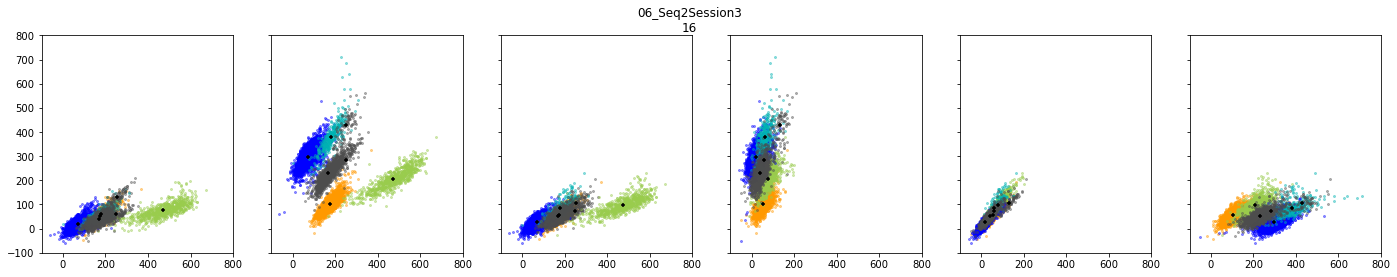

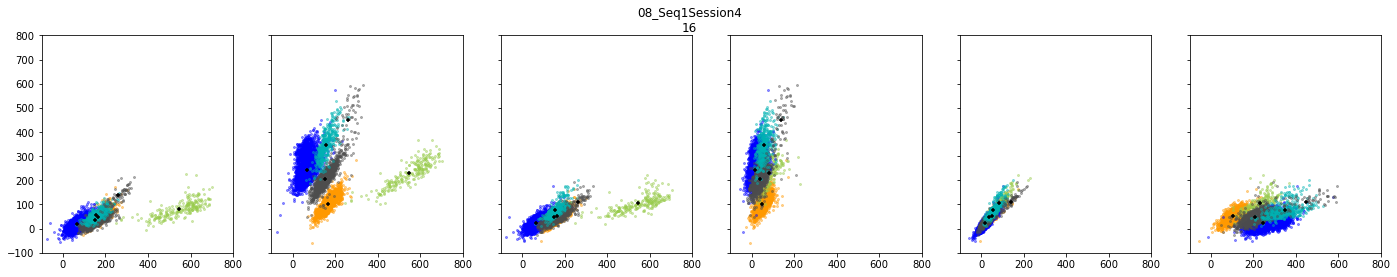

In [251]:
import scipy
'''example how to load mat file back here'''

sort_group_id=16
maxV=800
session1_name=session_names[2]
matfile_path = (Footprint() & {"nwb_file_name":nwb_copy_file_name,
               "sort_group_id":sort_group_id,
               "sort_interval_name":session1_name}).fetch1('matfile_path')
Amat=scipy.io.loadmat(matfile_path)
A1 = Amat['A']
ID1 = Amat['ind'].ravel()
centroid1 = Amat['centroids1']


session2_name=session_names[3]
matfile_path = (Footprint() & {"nwb_file_name":nwb_copy_file_name,
               "sort_group_id":sort_group_id,
               "sort_interval_name":session2_name}).fetch1('matfile_path')

Amat=scipy.io.loadmat(matfile_path)
A2 = Amat['A']
ID2 = Amat['ind'].ravel()
centroid2 = Amat['centroids1']

key = {'nwb_file_name':nwb_copy_file_name,"sort_group_id":sort_group_id,
       "sort_interval_name1":session1_name,"sort_interval_name2":session2_name}

matfile_path = (Tracking() & key).fetch1('matfile_path')
mat_result=mat73.loadmat(matfile_path)
tracking=mat_result['pairs'].reshape((-1,2))

accepted_units1 = np.unique(ID1)
accepted_units2 = np.unique(ID2)
colorvector1=np.zeros((len(accepted_units1),3))+0.3
colorvector2=np.zeros((len(accepted_units2),3))+0.3
for r_ind in range(tracking.shape[0]):
    u1,u2=tracking[r_ind]
    ind1=np.argwhere(accepted_units1==u1).ravel()
    ind2=np.argwhere(accepted_units2==u2).ravel()
    c = color_palet[r_ind % color_palet.shape[0]]
    colorvector1[ind1,:]=c
    colorvector2[ind2,:]=c
    
fig,axes = plot_tetrode(A1,ID1,centroid1,colorvector1,maxV)
fig.suptitle(session1_name+'\n'+str(sort_group_id))

fig,axes = plot_tetrode(A2,ID2,centroid2,colorvector2,maxV)
fig.suptitle(session2_name+'\n'+str(sort_group_id))


## END HERE

In [241]:
from mpl_toolkits.mplot3d import Axes3D
pair3=[[0,1,2],[0,2,3],[0,1,3],[1,2,3]]  #tetrode channel pairs

In [228]:
def plot_tetrode3d(spatial_footprint,ind,centroids,colorvector=[],voltageMax=0):
    '''
    spatial_footprint: (number of spikes x 4 channels of tetrode) negative voltage mV
    ind: (number of spikes) unit id for each spike
    centroids: (2 x 6 x number of units) 6 is 6 pairs of
    colorvector: optional for plotting each spike in different colors
    '''
    color_palet = np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
    color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly
    
    accepted_units = np.unique(ind)

    if len(colorvector)==0:
        colorvector=[]
        color_ind=0
        for u in accepted_units:
            colorvector.append(color_palet[color_ind % color_palet.shape[0]])
            color_ind = color_ind+1
        
    

    ## get amplitude and get centroids
    for p in range(4):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        color_ind=0
        for u in accepted_units:
            e1,e2,e3=pair3[p]
            x = spatial_footprint[ind==u,e1]
            y = spatial_footprint[ind==u,e2]
            z = spatial_footprint[ind==u,e3]
            ax.scatter(x,y,z,color=colorvector[color_ind], s=4,alpha = 0.4)
            color_ind = color_ind+1
        if voltageMax > 0:
            ax.set_xlim([-100, voltageMax])
            ax.set_ylim([-100, voltageMax])
            ax.set_zlim([-100, voltageMax])
        

    ## plot centroids
    # color_ind=0
    # for u in accepted_units:
    #     for p in range(4):
    #         e1,e2=pair[p]
    #         axes[p].scatter(centroids[color_ind,e1],centroids[color_ind,e2],c='k', marker='+',s=12)
    #     color_ind = color_ind+1
    
    

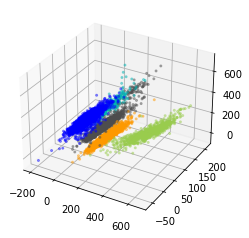

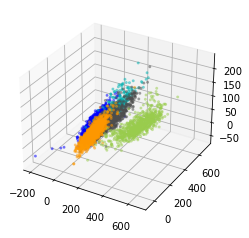

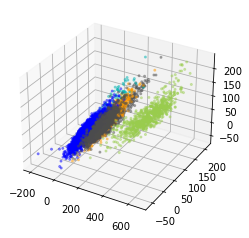

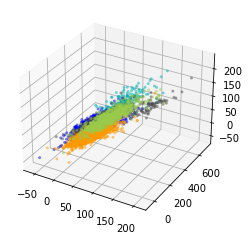

In [252]:
plot_tetrode3d(A1,ID1,centroid1,colorvector1)

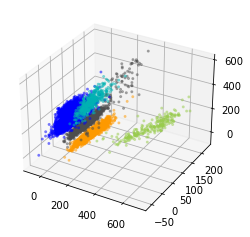

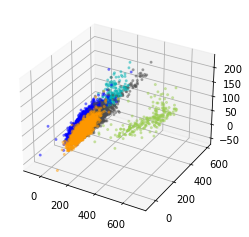

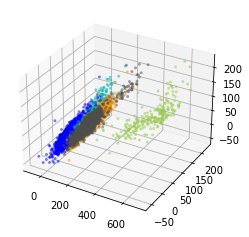

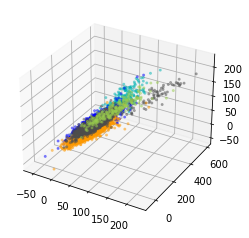

In [253]:
plot_tetrode3d(A2,ID2,centroid2,colorvector2)

In [47]:
H = 0
for u in accepted_units1:
    H_, xedges, yedges = np.histogram2d(waves1[u][:,0],waves1[u][:,1],[np.arange(0,1000,5),np.arange(0,1000,5)])
    H = H_ + H

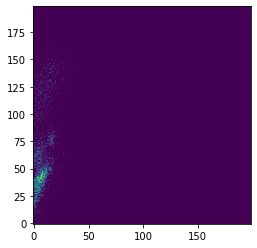

In [49]:
plt.imshow(H.T,interpolation='nearest', origin='lower')

In [52]:
from scipy.io import savemat
mdic = {"centroids1": centroids1, "centroids2": centroids2}
tracking_path='/cumulus/shijie/recording_pilot/eliot/tracking/'
savemat(os.path.join(tracking_path,"centroids.mat"), mdic)